## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option("display.max_columns", 200)
sns.set_theme()



## Load and Explore the Taxi and Zone Data

In [3]:
# Load Data
taxi = pd.read_csv('taxi_data.csv')
zones = pd.read_csv('taxi_zone_lookup.csv')

display(taxi.head(3))
display(zones.head(3))

/var/folders/qk/vdr0dvt91yj5p8tdhjkrzflh0000gn/T/ipykernel_24002/1268279586.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  taxi = pd.read_csv('taxi_data.csv')


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,2,2025-08-01 00:52:23,2025-08-01 01:12:20,1.0,8.44,1.0,N,138,141,1,33.8,6.0,0.5,5.00,6.94,1.0,57.49,2.5,1.75,0.00
1,2,2025-08-01 00:03:01,2025-08-01 00:15:33,2.0,4.98,1.0,N,138,193,1,21.2,6.0,0.5,0.00,0.00,1.0,30.45,0.0,1.75,0.00
2,7,2025-08-01 00:24:38,2025-08-01 00:24:38,2.0,1.89,1.0,N,249,45,1,14.2,0.0,0.5,3.99,0.00,1.0,23.94,2.5,0.00,0.75


,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone


#### Explore Data Types

In [12]:
taxi.info()
print("--------------------------------")
zones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3574091 entries, 0 to 3574090
Data columns (total 20 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
 18  Airport_fee            float64
 19  cbd_congestion_fee     float64
dtypes: float64(13), int64(4), object(3)
memory usage: 545.4+ MB
------------------------------

### Explore Missing Values

In [13]:
# Missing values for taxi data
display(taxi.isnull().sum())

# Missing values for zones data
display(zones.isnull().sum())

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          886234
trip_distance                 0
RatecodeID               886234
store_and_fwd_flag       886234
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     886234
Airport_fee              886234
cbd_congestion_fee            0
dtype: int64

LocationID      0
Borough         1
Zone            1
service_zone    2
dtype: int64

### Convert the Date and Time to timesereies data. Also convert trip duration to minutes and create new column to explore

In [14]:
# Convert pickup and dropoff to datetime
taxi["tpep_pickup_datetime"] = pd.to_datetime(taxi["tpep_pickup_datetime"])
taxi["tpep_dropoff_datetime"] = pd.to_datetime(taxi["tpep_dropoff_datetime"])

# Trip duration in minutes
taxi["duration_min"] = ((taxi["tpep_dropoff_datetime"] - taxi["tpep_pickup_datetime"]).dt.total_seconds() / 60).round(2)
taxi[["tpep_pickup_datetime", "tpep_dropoff_datetime", "duration_min"]].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,duration_min
0,2025-08-01 00:52:23,2025-08-01 01:12:20,19.95
1,2025-08-01 00:03:01,2025-08-01 00:15:33,12.53
2,2025-08-01 00:24:38,2025-08-01 00:24:38,0.00
3,2025-08-01 00:48:19,2025-08-01 00:48:19,0.00
4,2025-08-01 00:25:34,2025-08-01 00:33:18,7.73


### Identify the Airport Zones and the Manhattan Zones we are working with

In [ ]:
# Look at airport zones
airports_lookup = zones[zones["Zone"].str.contains("Airport", case=False, na=False)]
print(airports_lookup)

# Get the IDs of the airports
JFK_ID = 132
LGA_ID = 138 
airport_ids = [JFK_ID, LGA_ID]   

# All Manhattan pickup zones with LocationID and Zone
manhattan_zones = zones.loc[zones["Borough"] == "Manhattan", ["LocationID","Zone"]].copy()
manhattan_ids = manhattan_zones["LocationID"].tolist()

# View the zones and IDs
manhattan_zones.head()
len(manhattan_zones)

     LocationID Borough               Zone service_zone
0             1     EWR     Newark Airport          EWR
131         132  Queens        JFK Airport     Airports
137         138  Queens  LaGuardia Airport     Airports


69

### Outlier Detection and Removal

##### Restricted the data to trips from Manhattan to JFK or LaGuardia, which gave us about 50,297 rides. Trip durations ranged from 0 minutes to roughly 1,438 minutes (24 hoursish), which is clearly unrealistic for an airport trip. The raw histogram shows a heavy right tail driven by these extreme values.

Manhattan to JFK/LGA trips (before outlier removal): (50297, 21)


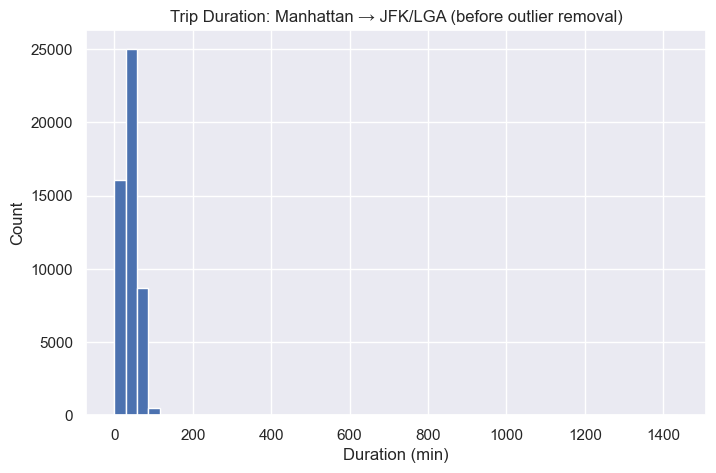

In [17]:
# Manhattan to JFK/LGA only
mask = taxi["PULocationID"].isin(manhattan_ids) & taxi["DOLocationID"].isin(airport_ids)

taxi_ma = taxi[mask]
print("Manhattan to JFK/LGA trips (before outlier removal):", taxi_ma.shape)

# Plot duration distribution to spot outliers, zooming in to more relevant duration range
plt.figure(figsize=(8,5))
plt.hist(taxi_ma["duration_min"], bins=50)
plt.title("Trip Duration: Manhattan → JFK/LGA (before outlier removal)")
plt.xlabel("Duration (min)")
plt.ylabel("Count")
plt.show()

Trips with duration <=3 or >=180: 696
After outlier removal: (49601, 21)


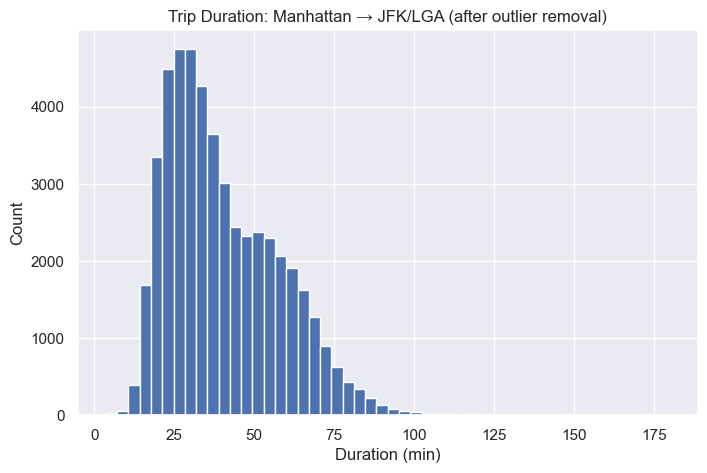

In [ ]:
# Outlier mask
mask_outliers = (taxi_ma["duration_min"] <= 3) | (taxi_ma["duration_min"] >= 180)
print("Trips with duration <=3 or >=180:", mask_outliers.sum())

# Drop outliers into a new DF to see what's going on
taxi_clean = taxi_ma.loc[~mask_outliers].copy()
print("After outlier removal:", taxi_clean.shape)

# Replace the old taxi DF with the cleaned 
taxi = taxi_clean

# Plot histogram after outlier removal
plt.figure(figsize=(8,5))
plt.hist(taxi["duration_min"], bins=50)
plt.title("Trip Duration: Manhattan → JFK/LGA (after outlier removal)")
plt.xlabel("Duration (min)")
plt.ylabel("Count")
plt.show()


##### To remove likely trip errors and non standard rides (multi stop, etc.) I treated trips shorter than 3 minutes or longer than 180 minutes as outliers. This affected 696 trips (only about 1.4% of the data), leaving us with 49,601 rides for modeling. The cleaned distribution still has a right tail, but now reflects plausible airport travel times.

In [ ]:
# Add pickup zone name to the cleaned taxi data
taxi = taxi.merge(
    manhattan_zones.rename(columns={"LocationID": "PULocationID", "Zone": "pickup_zone"}),
    on="PULocationID",
    how="left"
)

# Quick check
taxi[["PULocationID", "pickup_zone", "DOLocationID", "duration_min"]].head()


,PULocationID,pickup_zone,DOLocationID,duration_min
0,230,Times Sq/Theatre District,132,31.47
1,230,Times Sq/Theatre District,132,31.47
2,164,Midtown South,132,29.30
3,224,Stuy Town/Peter Cooper Village,132,28.87
4,48,Clinton East,132,31.57


### Time Features and Airport Labels

In [12]:
# Hour of day and day of week
taxi["hour"] = taxi["tpep_pickup_datetime"].dt.hour
taxi["day_of_week"] = taxi["tpep_pickup_datetime"].dt.dayofweek

# Map airport ID to readable name
airport_map = {JFK_ID: "JFK", LGA_ID: "LGA"}
taxi["airport"] = taxi["DOLocationID"].map(airport_map)

# Quick check
taxi[["PULocationID", "pickup_zone", "DOLocationID", "airport", "hour", "day_of_week", "duration_min"]].head()


,PULocationID,pickup_zone,DOLocationID,airport,hour,day_of_week,duration_min
0,230,Times Sq/Theatre District,132,JFK,0,4,31.47
1,230,Times Sq/Theatre District,132,JFK,0,4,31.47
2,164,Midtown South,132,JFK,0,4,29.30
3,224,Stuy Town/Peter Cooper Village,132,JFK,1,4,28.87
4,48,Clinton East,132,JFK,2,4,31.57


In [13]:
# Baseline which is the median duration by pickup zone, airport, hour.
baseline = (taxi.groupby(["PULocationID", "airport", "hour"])["duration_min"].median().rename("median_duration").reset_index())
baseline.head()

# Merge baseline back into main df
taxi = taxi.merge(
    baseline,
    on=["PULocationID", "airport", "hour"],
    how="left")

# Defining late as more than 20% longer than median for that zone+airport+hour
taxi["late"] = (taxi["duration_min"] > 1.2 * taxi["median_duration"]).astype(int)
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,congestion_surcharge,Airport_fee,cbd_congestion_fee,duration_min,pickup_zone,hour,day_of_week,airport,median_duration,late
0,2,2025-08-01 00:40:36,2025-08-01 01:12:04,3.0,17.09,2.0,N,230,132,4,...,-2.5,0.0,-0.75,31.47,Times Sq/Theatre District,0,4,JFK,31.47,0
1,2,2025-08-01 00:40:36,2025-08-01 01:12:04,3.0,17.09,2.0,N,230,132,4,...,2.5,0.0,0.75,31.47,Times Sq/Theatre District,0,4,JFK,31.47,0
2,2,2025-08-01 00:18:05,2025-08-01 00:47:23,1.0,17.16,2.0,N,164,132,2,...,2.5,0.0,0.75,29.30,Midtown South,0,4,JFK,29.30,0
3,2,2025-08-01 01:08:09,2025-08-01 01:37:01,1.0,17.63,2.0,N,224,132,1,...,2.5,0.0,0.75,28.87,Stuy Town/Peter Cooper Village,1,4,JFK,28.87,0
4,2,2025-08-01 02:00:39,2025-08-01 02:32:13,1.0,17.61,2.0,N,48,132,2,...,2.5,0.0,0.75,31.57,Clinton East,2,4,JFK,32.72,0


### Late Class Balance

In [14]:
# Check balance of late class
taxi["late"].value_counts(normalize=True)
taxi.groupby("airport")["late"].value_counts(normalize=True)

airport  late
JFK      0       0.853124
         1       0.146876
LGA      0       0.831227
         1       0.168773
Name: proportion, dtype: float64

### Distribution of Trip Duration

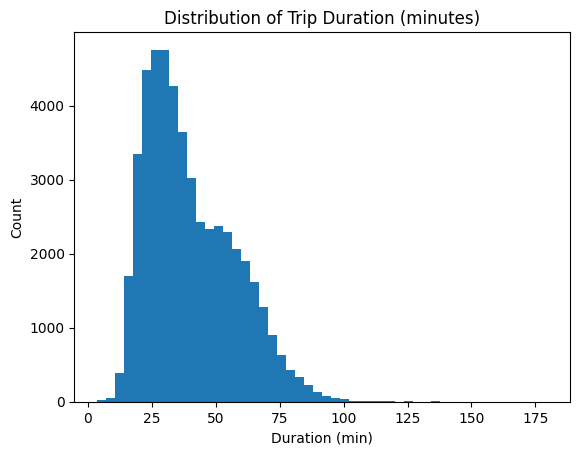

In [15]:
# Distribution of Trip Duration
plt.hist(taxi["duration_min"], bins=50)
plt.title("Distribution of Trip Duration (minutes)")
plt.xlabel("Duration (min)")
plt.ylabel("Count")
plt.show()

### Trip Duration by Airport

<Figure size 600x500 with 0 Axes>

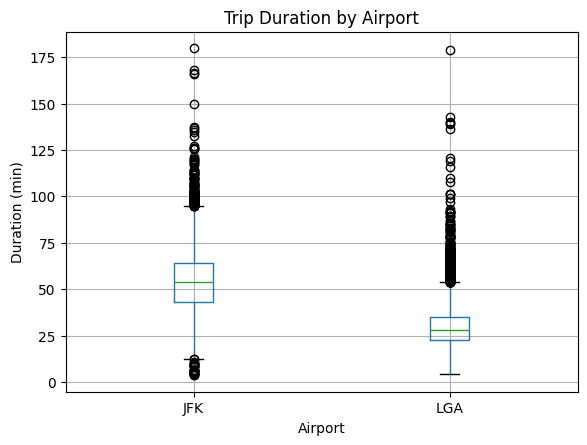

In [ ]:
plt.figure(figsize=(6, 5))
taxi.boxplot(column="duration_min", by="airport")
plt.title("Trip Duration by Airport")
plt.suptitle("")  
plt.xlabel("Airport")
plt.ylabel("Duration (min)")
plt.show()

### Average Trip Duration by Hour and Airport

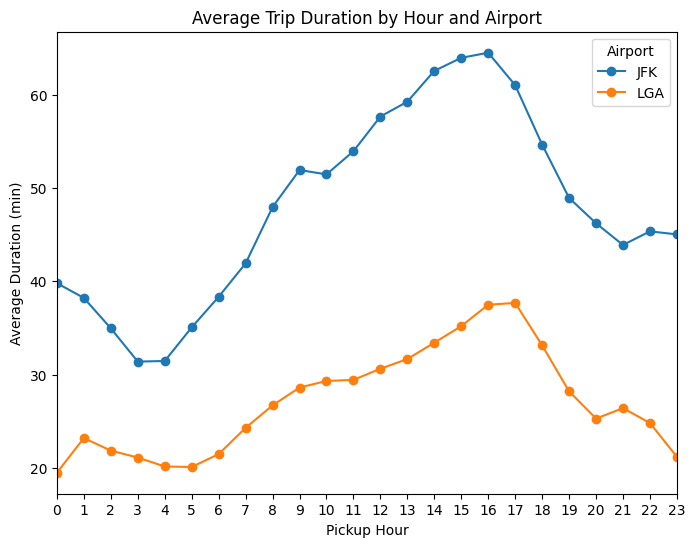

In [ ]:
# Average duration by pickup hour and airport
avg_by_hour = (taxi.groupby(["hour", "airport"])["duration_min"].mean().reset_index().sort_values("hour"))

fig, ax = plt.subplots(figsize=(8, 6))

# One line per airport
for airport, grp in avg_by_hour.groupby("airport"):
    ax.plot(grp["hour"], grp["duration_min"], marker="o", label=airport)

# Plot 
ax.set_title("Average Trip Duration by Hour and Airport")
ax.set_xlabel("Pickup Hour")
ax.set_ylabel("Average Duration (min)")
ax.set_xticks(range(0, 24))   # 0–23
ax.set_xlim(0, 23)
ax.legend(title="Airport")
plt.show()


### Average Trip Duration by Day of Week 

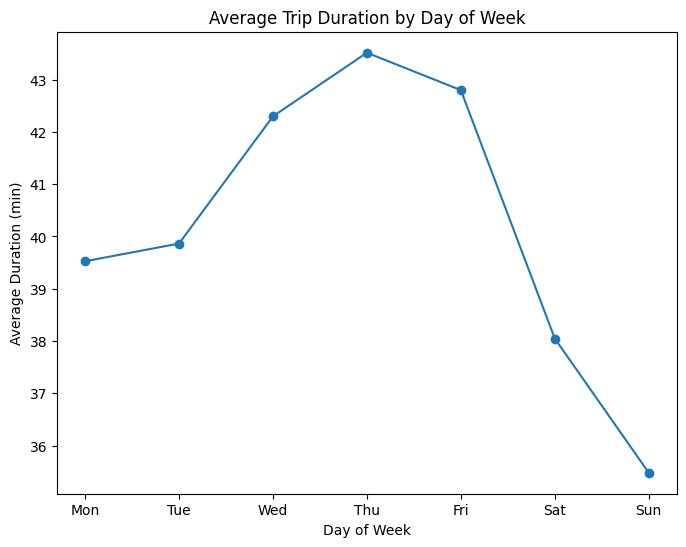

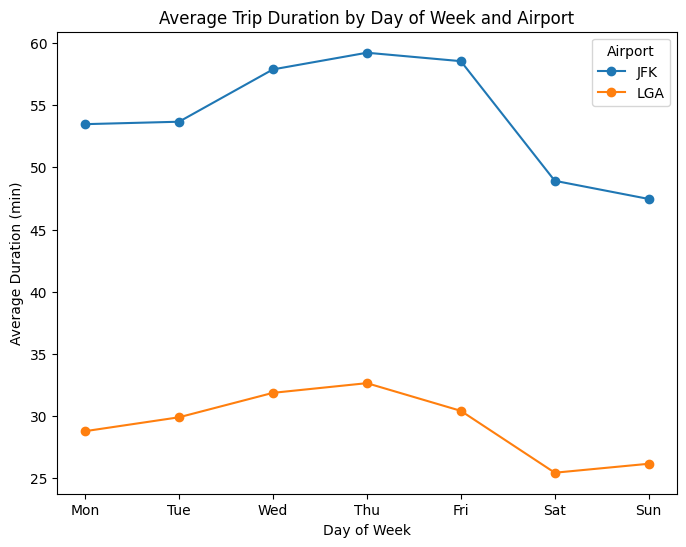

In [18]:
avg_by_day = (taxi.groupby("day_of_week")["duration_min"].mean().reset_index())

plt.figure(figsize=(8, 6))
plt.plot(avg_by_day["day_of_week"], avg_by_day["duration_min"], marker="o")
plt.title("Average Trip Duration by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Duration (min)")
plt.xticks(range(0, 7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.show()


# Average trip duration by day of week and airport
avg_by_day_airport = (taxi.groupby(["day_of_week", "airport"])["duration_min"].mean().reset_index())

plt.figure(figsize=(8, 6))
for airport, grp in avg_by_day_airport.groupby("airport"):
    plt.plot(grp["day_of_week"], grp["duration_min"], marker="o", label=airport)
plt.title("Average Trip Duration by Day of Week and Airport")
plt.xlabel("Day of Week")
plt.ylabel("Average Duration (min)")
plt.xticks(range(0, 7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.legend(title="Airport")
plt.show()


### Late Rate by Hour (All Airports)

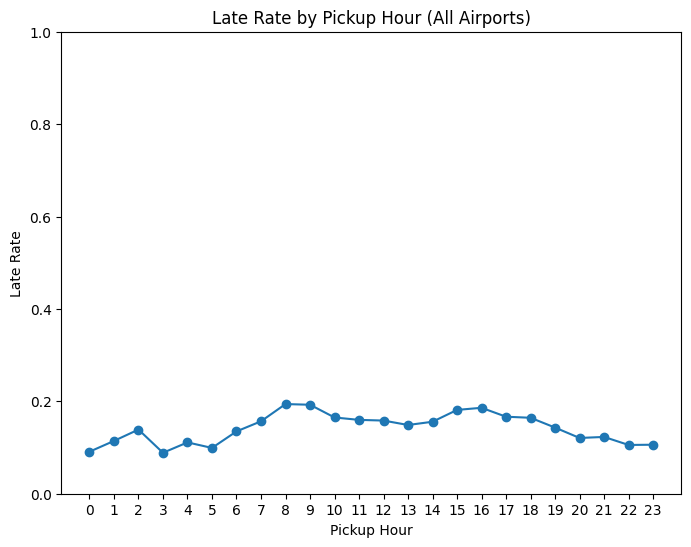

In [19]:
# Late Rate by Hour
late_by_hour = (taxi.groupby("hour")["late"].mean().reset_index().rename(columns={"late": "late_rate"}))

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(late_by_hour["hour"], late_by_hour["late_rate"], marker="o")
ax.set_title("Late Rate by Pickup Hour (All Airports)")
ax.set_xlabel("Pickup Hour")
ax.set_ylabel("Late Rate")
ax.set_xticks(range(0, 24))
ax.set_ylim(0, 1)
plt.show()

## Late Rate by Hour AND Airport

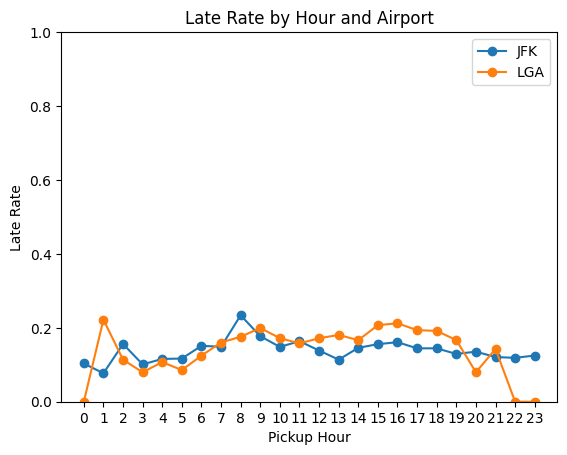

In [20]:
# Late Rate by Hour and Airport
late_by_airport_hour = (taxi.groupby(["airport", "hour"])["late"].mean().reset_index().rename(columns={"late": "late_rate"}))

for a in late_by_airport_hour["airport"].unique():
    subset = late_by_airport_hour[late_by_airport_hour["airport"] == a]
    plt.plot(subset["hour"], subset["late_rate"], marker="o", label=a)

# PLot
plt.title("Late Rate by Hour and Airport")
plt.xlabel("Pickup Hour")
plt.ylabel("Late Rate")
plt.xticks(range(0, 24))
plt.ylim(0, 1)
plt.legend()
plt.show()


### Late Rate by Day of Week

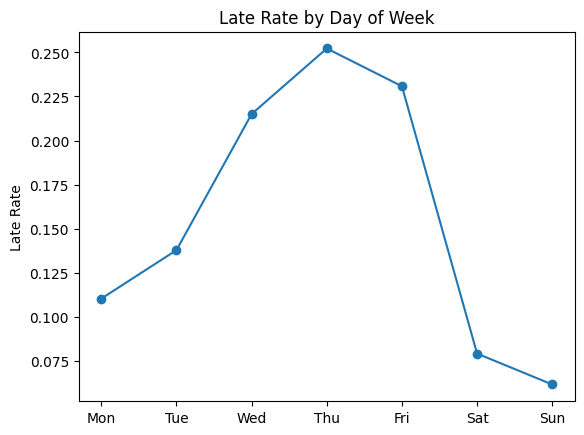

In [21]:
late_by_dow = (
    taxi.groupby("day_of_week")["late"]
    .mean()
    .reset_index()
)
plt.plot(late_by_dow["day_of_week"], late_by_dow["late"], marker="o")
plt.xticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.title("Late Rate by Day of Week")
plt.ylabel("Late Rate")
plt.show()


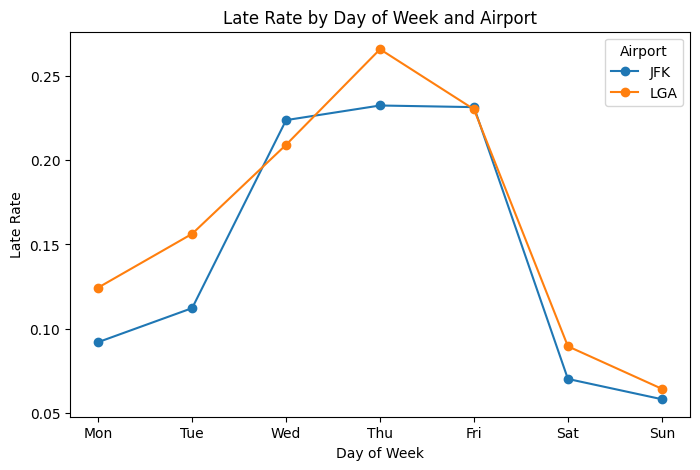

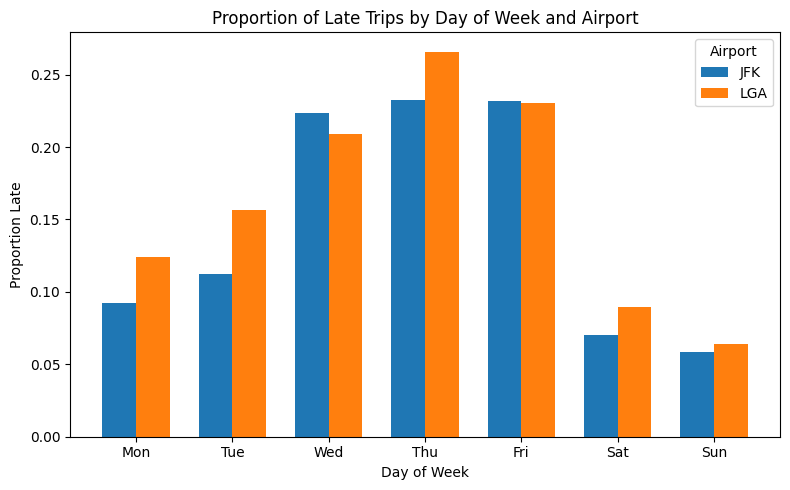

In [ ]:
late_by_dow_airport = (
    taxi.groupby(["day_of_week", "airport"])["late"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))
for airport in late_by_dow_airport["airport"].unique():
    plt.plot(
        late_by_dow_airport[late_by_dow_airport["airport"] == airport]["day_of_week"],
        late_by_dow_airport[late_by_dow_airport["airport"] == airport]["late"],
        marker="o",
        label=airport
    )
plt.xticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.title("Late Rate by Day of Week and Airport")
plt.ylabel("Late Rate")
plt.xlabel("Day of Week")
plt.legend(title="Airport")
plt.show()


# Percentage late by day of week, grouped bar by airport
late_by_dow_airport = (taxi.groupby(["day_of_week", "airport"])["late"].mean().reset_index())

plt.figure(figsize=(8, 5))
width = 0.35
airports = late_by_dow_airport["airport"].unique()
days = list(range(7))
x = np.arange(len(days))

for i, airport in enumerate(airports):
    y = late_by_dow_airport[late_by_dow_airport["airport"] == airport].set_index("day_of_week")["late"].reindex(days, fill_value=0).values
    plt.bar(x + i*width, y, width=width, label=airport)

plt.xticks(x + width/2, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.title("Proportion of Late Trips by Day of Week and Airport")
plt.ylabel("Proportion Late")
plt.xlabel("Day of Week")
plt.legend(title="Airport")
plt.tight_layout()
plt.show()



### Zone EDA

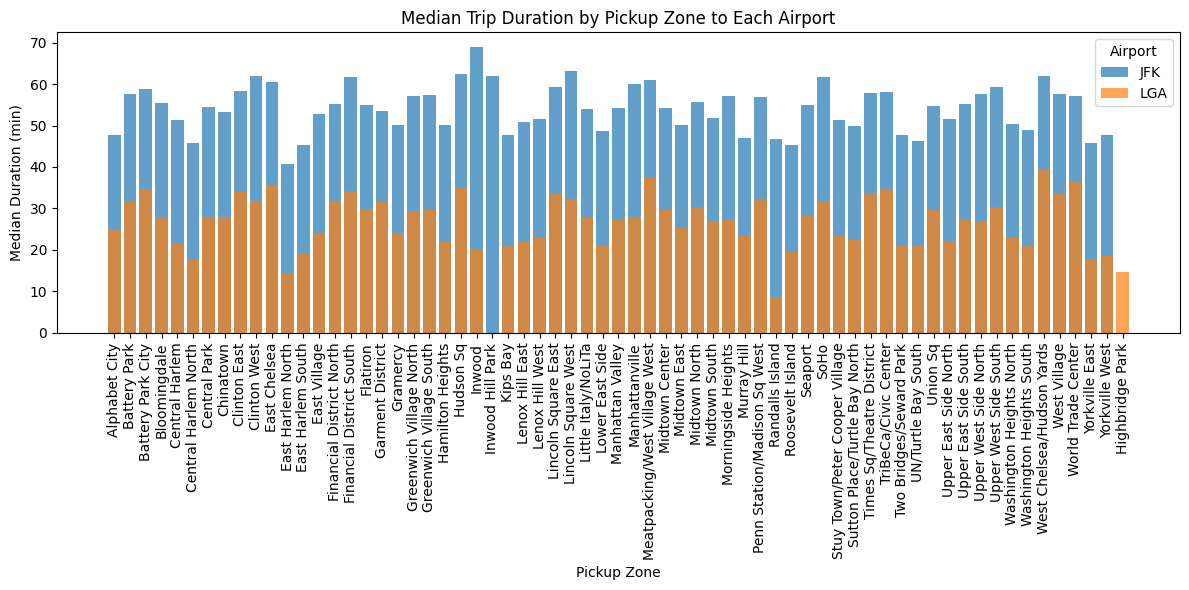

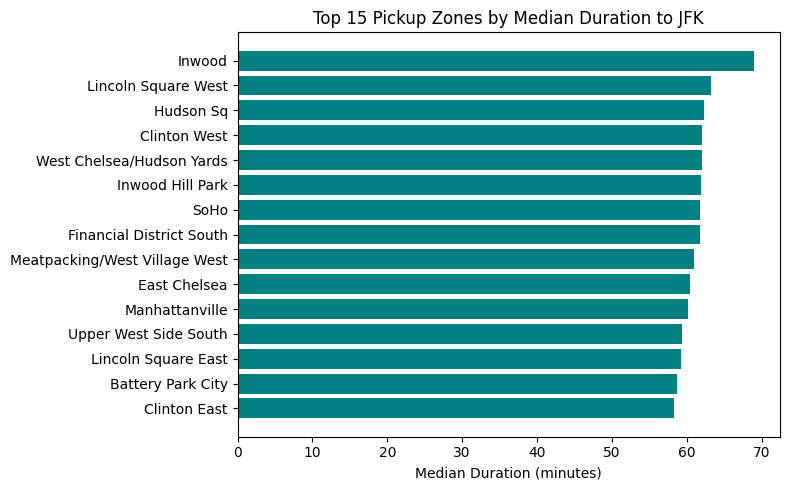

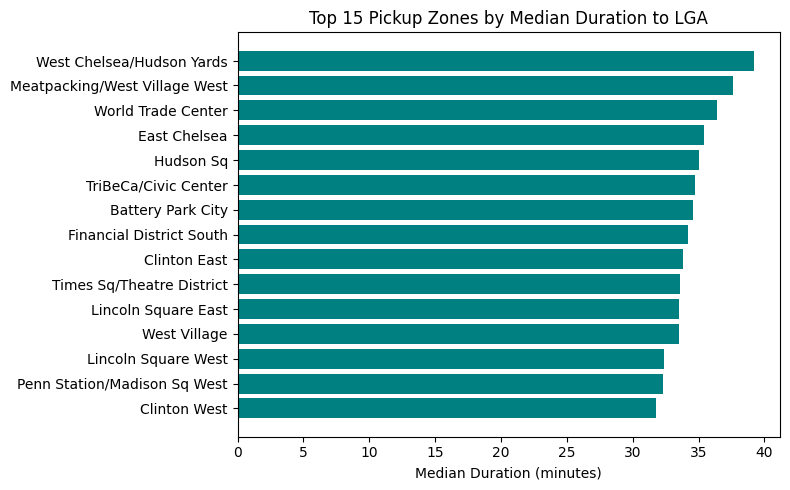

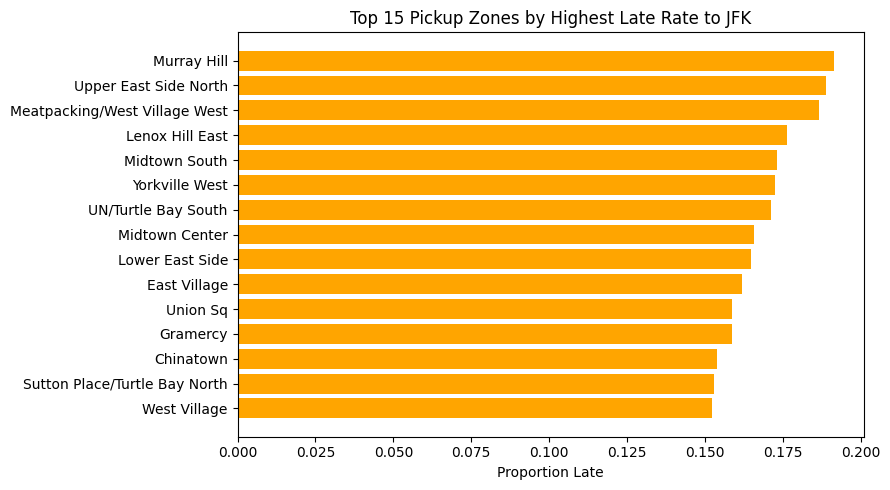

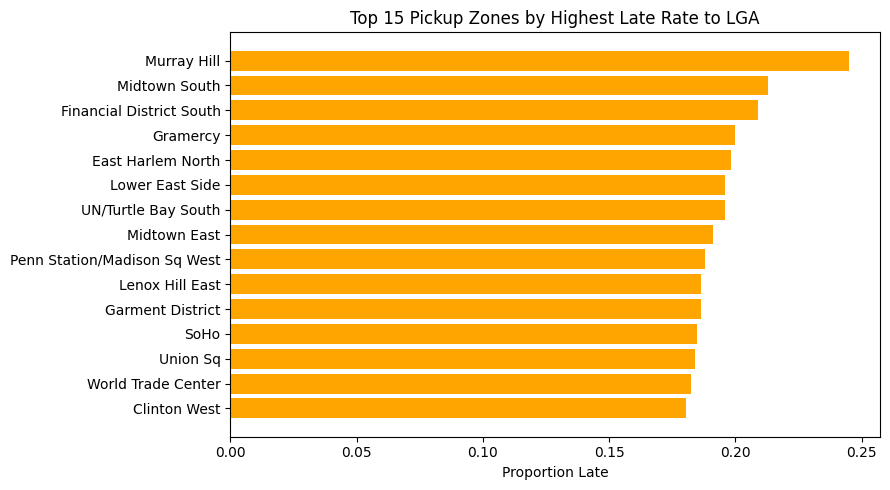

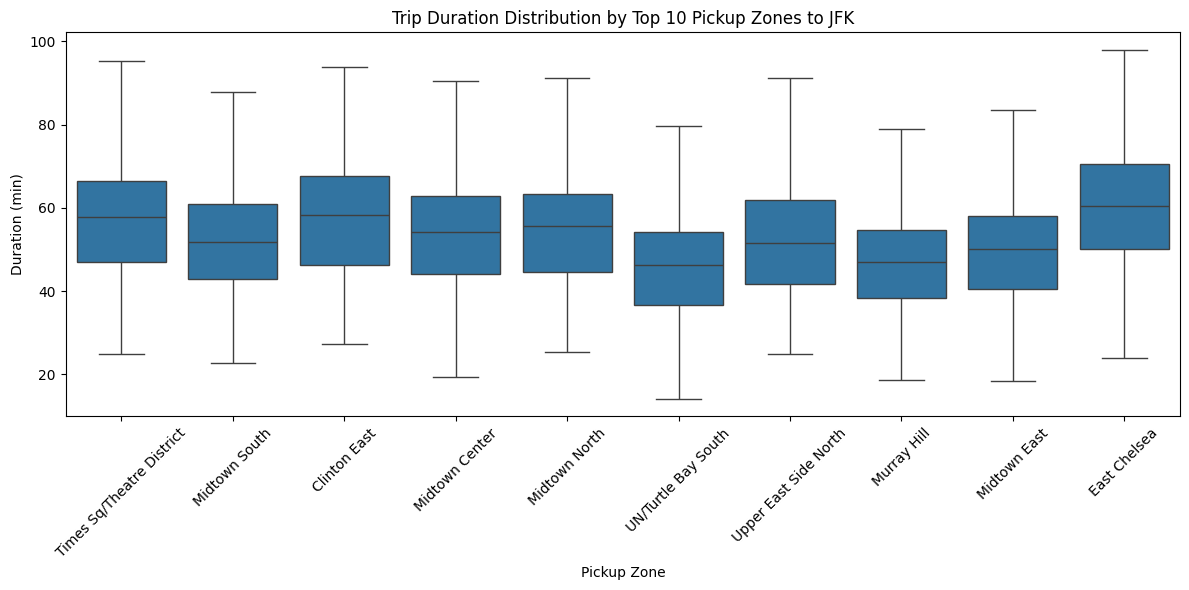

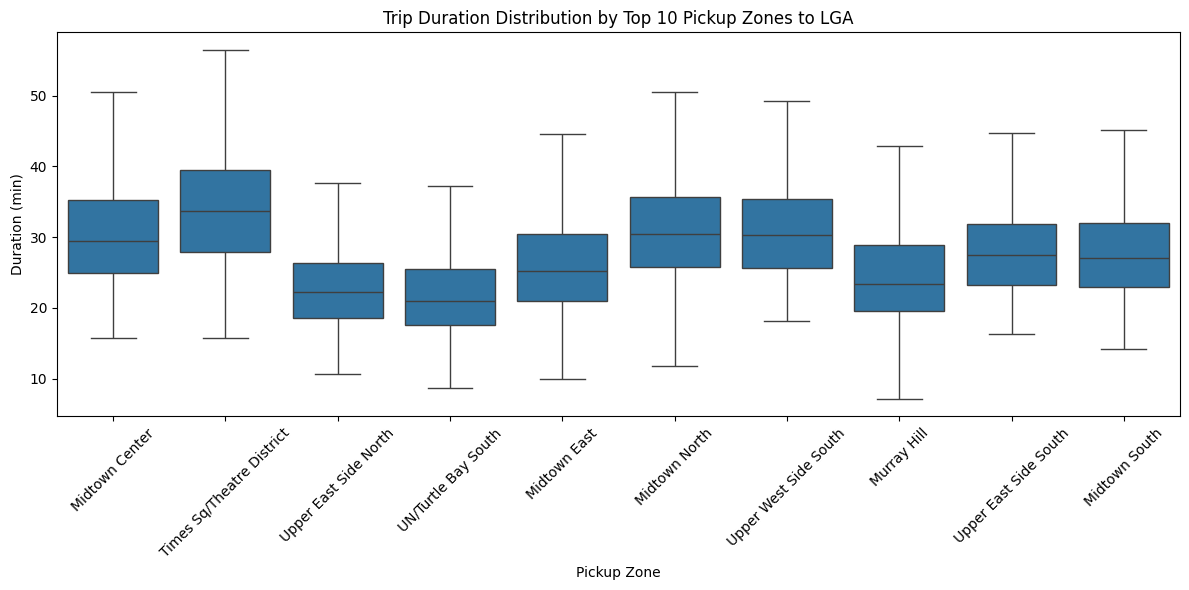

,pickup_zone,airport,n_trips,median_duration,late_rate
97,Times Sq/Theatre District,LGA,3381,33.630,0.154392
96,Times Sq/Theatre District,JFK,2540,57.800,0.143701
71,Midtown Center,LGA,2532,29.525,0.177725
75,Midtown North,LGA,1607,30.420,0.165526
73,Midtown East,LGA,1601,25.180,0.191131
70,Midtown Center,JFK,1417,54.130,0.165843
81,Murray Hill,LGA,1098,23.385,0.244991
74,Midtown North,JFK,1038,55.600,0.141618
77,Midtown South,LGA,1020,26.990,0.212745
72,Midtown East,JFK,962,50.220,0.151767


In [24]:
# Duration by Pickup Zone 
plt.figure(figsize=(12, 6))
duration_by_zone_airport = (taxi.groupby(['pickup_zone', 'airport'])['duration_min'].median().reset_index())

# Plot
for airport in duration_by_zone_airport['airport'].unique():
    data = duration_by_zone_airport[duration_by_zone_airport['airport'] == airport]
    plt.bar(data['pickup_zone'], data['duration_min'], label=airport, alpha=0.7)
plt.xlabel('Pickup Zone')
plt.ylabel('Median Duration (min)')
plt.title('Median Trip Duration by Pickup Zone to Each Airport')
plt.legend(title="Airport")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#  Top Pickup Zones by Median Duration (to JFK and LGA)
for airport in ['JFK', 'LGA']:
    top_durations = duration_by_zone_airport[duration_by_zone_airport['airport']==airport]
    top_durations = top_durations.sort_values('duration_min', ascending=False).head(15)
    plt.figure(figsize=(8, 5))
    plt.barh(top_durations['pickup_zone'], top_durations['duration_min'], color='teal')
    plt.xlabel('Median Duration (minutes)')
    plt.title(f'Top 15 Pickup Zones by Median Duration to {airport}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Late Rate by Pickup Zone to each airport
late_by_zone_airport = (taxi.groupby(['pickup_zone', 'airport'])['late'].mean().reset_index())
for airport in late_by_zone_airport['airport'].unique():
    zone_late = late_by_zone_airport[late_by_zone_airport['airport']==airport]
    top_late = zone_late.sort_values('late', ascending=False).head(15)
    plt.figure(figsize=(9, 5))
    plt.barh(top_late['pickup_zone'], top_late['late'], color='orange')
    plt.xlabel('Proportion Late')
    plt.title(f'Top 15 Pickup Zones by Highest Late Rate to {airport}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Duration Distribution by Pickup Zone to JFK and LGA
import seaborn as sns

for airport in ['JFK', 'LGA']:
    zone_counts = taxi[taxi['airport']==airport]['pickup_zone'].value_counts()
    top_zones = zone_counts.head(10).index.tolist()
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='pickup_zone', y='duration_min',
        data=taxi[(taxi['airport']==airport) & (taxi['pickup_zone'].isin(top_zones))],
        showfliers=False
    )
    plt.title(f'Trip Duration Distribution by Top 10 Pickup Zones to {airport}')
    plt.xlabel('Pickup Zone')
    plt.ylabel('Duration (min)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#  Zone EDA Summary Table 
zone_summary = taxi.groupby(['pickup_zone', 'airport']).agg(
    n_trips = ('duration_min', 'count'),
    median_duration = ('duration_min', 'median'),
    late_rate = ('late', 'mean')
).reset_index()
display(zone_summary.sort_values('n_trips', ascending=False).head(15))